# Proyecto de Pruebas A/B

## Introducción

En este estudio analítico, se llevó a cabo una prueba A/B en una tienda en línea internacional con el objetivo de evaluar la efectividad de un nuevo embudo de pago. La prueba, denominada `recommender_system_test`, fue diseñada para introducir un sistema de recomendaciones mejorado y compararlo con el embudo de pago existente, que servía como grupo de control. El sistema de recomendaciones mejorado busca personalizar las sugerencias de productos para cada usuario, aumentando así las probabilidades de conversión en cada etapa del embudo de ventas.


### Objetivos del estudio:


- Evaluar si el nuevo embudo de pago mejora las tasas de conversión de los usuarios en las etapas clave del embudo de ventas: `product_page`, `product_cart`, y `purchase`.
- Determinar si existen diferencias estadísticamente significativas en las tasas de conversión entre el grupo de control y el grupo experimental.
- Proporcionar recomendaciones basadas en los resultados obtenidos para optimizar las estrategias de ventas y marketing de la tienda en línea.

Este informe detallará el proceso de análisis de datos, desde la carga inicial de los conjuntos de datos hasta la evaluación de resultados y conclusiones derivadas del estudio de prueba A/B.

### Importación de librerías

In [1]:
# Importación de Librerías
import pandas as pd             # Para la manipulación y análisis de datos
import numpy as np              # Para operaciones numéricas y cálculos estadísticos
import matplotlib.pyplot as plt # Para visualización de datos
import seaborn as sns           # Para visualización de datos más atractiva
from scipy import stats         # Para pruebas estadísticas
from statsmodels.stats.proportion import proportions_ztest # Para la prueba Z de proporciones

# Configuración de estilo para los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9, 5)


### Carga de datos

In [2]:
# Función para cargar los datasets y proporcionar una descripción inicial
def cargar_datasets(paths):
    datasets = {}
    for name, path in paths.items():
        datasets[name] = pd.read_csv(path)
        print(f"\n{'-'*50}\n{name}:")
        display(datasets[name].head())
    return datasets

# Rutas de los archivos
paths = {
    "marketing_events": '/datasets/ab_project_marketing_events_us.csv',
    "new_users": '/datasets/final_ab_new_users_upd_us.csv',
    "events": '/datasets/final_ab_events_upd_us.csv',
    "participants": '/datasets/final_ab_participants_upd_us.csv'
}

# Cargar los datasets
datasets = cargar_datasets(paths)

# Asignar los datasets cargados a variables individuales
marketing_events = datasets['marketing_events']
new_users = datasets['new_users']
events = datasets['events']
participants = datasets['participants']



--------------------------------------------------
marketing_events:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



--------------------------------------------------
new_users:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



--------------------------------------------------
events:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



--------------------------------------------------
participants:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


### Preparación de datos

In [3]:
def initial_data_analysis(data, name):
    print(f"\n{'='*50}\nAnálisis inicial del dataset: {name}\n{'='*50}")
    print(f"Tamaño del dataset: {data.shape}")
    print(f"Información del dataset:\n{data.info()}")
    print(f"Valores nulos en cada columna:\n{data.isnull().sum()}")
    print(f"Número de filas duplicadas: {data.duplicated().sum()}")
    print("="*50 + "\n")

initial_data_analysis(marketing_events, "Marketing Events")
initial_data_analysis(new_users, "New Users")
initial_data_analysis(events, "Events")
initial_data_analysis(participants, "Participants")



Análisis inicial del dataset: Marketing Events
Tamaño del dataset: (14, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
Información del dataset:
None
Valores nulos en cada columna:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Número de filas duplicadas: 0


Análisis inicial del dataset: New Users
Tamaño del dataset: (58703, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  objec

El dataset Marketing Events contiene un total de 14 entradas y 4 columnas. Todas las columnas están completas y no se encontraron filas duplicadas. Las columnas incluyen información sobre el nombre del evento de marketing, las regiones donde se llevó a cabo la campaña, y las fechas de inicio y finalización de cada evento, todas ellas de tipo objeto.

En cuanto al dataset New Users, se observa que contiene 58,703 registros distribuidos en 4 columnas. Todas las columnas están completas y no hay filas duplicadas. Las columnas incluyen el identificador de usuario, la fecha de registro inicial, la región desde la cual se registró el usuario, y el dispositivo utilizado para el registro, todas de tipo objeto. El dataset ocupa aproximadamente 1.8 MB en memoria.

En el dataset Events, se encontraron 423,761 registros distribuidos en 4 columnas. La mayoría de los registros están completos en las columnas de identificador de usuario, fecha y hora del evento, y nombre del evento. Sin embargo, la columna "details" que contiene datos adicionales para ciertos eventos presenta 363,447 valores nulos, lo cual podría requerir atención dependiendo del análisis específico que se realice. No se encontraron filas duplicadas en este dataset, y las columnas son una combinación de objetos y un float64 para los detalles.

Finalmente, el dataset Participants contiene 14,525 registros y 3 columnas, todas completas y sin valores nulos ni filas duplicadas. Las columnas incluyen el identificador de usuario, el grupo al que pertenece en la prueba A/B, y el nombre de la prueba A/B, todas ellas de tipo objeto y ocupando aproximadamente 340.6 KB en memoria.

Estos análisis proporcionan una visión inicial de la integridad y la estructura de cada dataset, estableciendo una base sólida para realizar análisis más detallados y la prueba A/B conforme sea necesario.

### Análisis de datos nulos

In [4]:
# Mostrar el dataste de events para ver que datos son los que estan nulos
datos_nulos = events[events.isnull().any(axis=1)].head(20)
datos_nulos

,user_id,event_dt,event_name,details
60314,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
60315,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
60316,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
60317,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
60318,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
60319,E6AF85675078215D,2020-12-07 16:23:47,product_cart,NaN
60320,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN
60321,AD8BFC204C0F14E4,2020-12-07 18:07:40,product_cart,NaN
60322,160121894010711F,2020-12-07 14:50:22,product_cart,NaN
60323,914FF952E23F1E75,2020-12-07 05:41:55,product_cart,NaN


In [5]:
# Función para analizar la distribución de valores nulos
def analyze_missing_values_distribution(data):
    # Filtrar filas con valores nulos
    missing_data = data[data.isnull().any(axis=1)]
    
    # Contar el total de filas con valores nulos
    total_missing = missing_data.shape[0]
    print(f"Total de filas con valores nulos: {total_missing}\n")
    
    # Distribución de valores nulos por columna
    missing_distribution = data.isnull().mean() * 100
    print("Distribución de valores nulos por columna:")
    print(missing_distribution)
    print("\n" + "-"*50 + "\n")
    
    return missing_data

# Análisis de distribución de valores nulos en el dataset de eventos
missing_data = analyze_missing_values_distribution(events)


Total de filas con valores nulos: 363447

Distribución de valores nulos por columna:
user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.766977
dtype: float64

--------------------------------------------------



In [6]:
# Función para analizar la relación entre datos nulos y otras variables
def analyze_missing_values_relationship(data, missing_data):
    # Comparar la distribución de eventos con y sin valores nulos
    print("Comparación de la distribución de eventos (con vs sin valores nulos):")
    print(data['event_name'].value_counts(normalize=True) * 100)
    print("\nDistribución de eventos con valores nulos:")
    print(missing_data['event_name'].value_counts(normalize=True) * 100)
    print("\n" + "-"*50 + "\n")
    
    # Análisis adicional que se considere relevante
    # Por ejemplo, ver si los usuarios con valores nulos en 'details' tienen un patrón específico
    print("Distribución de usuarios con valores nulos:")
    print(missing_data['user_id'].value_counts().head())
    print("\n" + "-"*50 + "\n")
    
    print("Distribución de fechas de eventos con valores nulos:")
    print(missing_data['event_dt'].value_counts().head())
    print("\n" + "-"*50 + "\n")
    
# Análisis de la relación de valores nulos con otras variables en el dataset de eventos
analyze_missing_values_relationship(events, missing_data)


Comparación de la distribución de eventos (con vs sin valores nulos):
login           43.058469
product_page    28.521266
purchase        14.233023
product_cart    14.187242
Name: event_name, dtype: float64

Distribución de eventos con valores nulos:
login           50.204019
product_page    33.254367
product_cart    16.541614
Name: event_name, dtype: float64

--------------------------------------------------

Distribución de usuarios con valores nulos:
DFE346880E238754    27
D0B5193D2F44F591    27
A3917F81482141F2    27
B06E6F4555C20B88    27
EE24C237DFB1ACEF    27
Name: user_id, dtype: int64

--------------------------------------------------

Distribución de fechas de eventos con valores nulos:
2020-12-20 04:24:41    8
2020-12-20 02:51:18    8
2020-12-18 14:43:42    8
2020-12-24 00:54:52    8
2020-12-14 18:54:55    8
Name: event_dt, dtype: int64

--------------------------------------------------



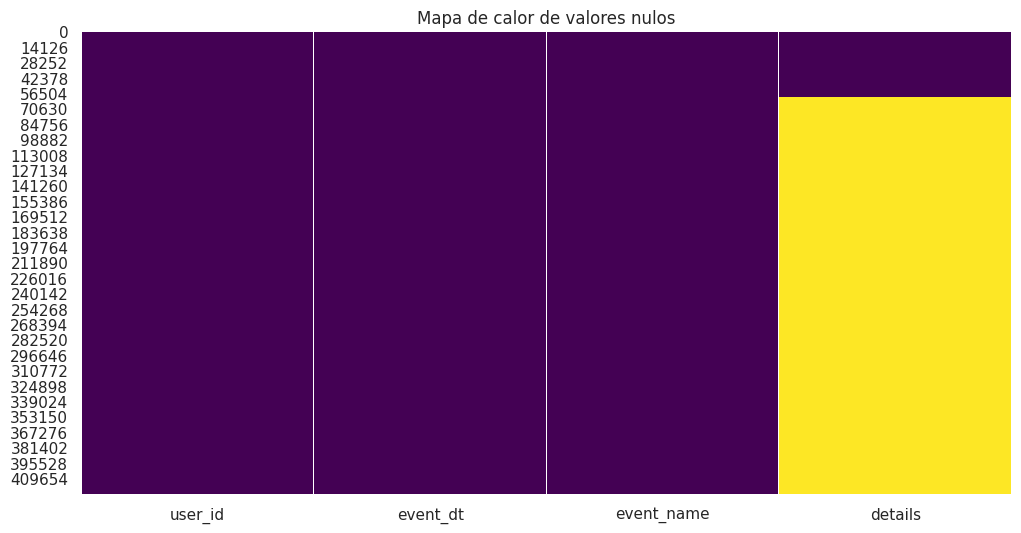

In [7]:
# Función para visualizar datos nulos
def visualize_missing_values(data):
    plt.figure(figsize=(12, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title("Mapa de calor de valores nulos")
    plt.show()

# Visualizar datos nulos en el dataset de eventos
visualize_missing_values(events)


El análisis exhaustivo de los valores nulos en el dataset `events` revela que un total de 363,447 filas, aproximadamente el 85.77% del total, contienen valores nulos en la columna `details`. Este alto porcentaje sugiere que la información en esta columna puede ser opcional o no siempre relevante para todos los eventos registrados. La columna `details` presenta valores nulos principalmente en eventos de tipo `login` y `product_page`, lo que indica que estos eventos pueden no requerir detalles adicionales para ser considerados válidos. Esta observación es fundamental para la decisión de imputar los valores nulos.

Por este motivo se plantea la imputación de los valores nulos con ceros en la columna `details` con base en varios factores. Primero, dado que los eventos `login` y `product_page` representan la mayoría de los valores nulos y estos eventos pueden no necesitar detalles adicionales, imputar con cero es una forma de estandarizar el dataset sin introducir sesgos. Además, esta estrategia evita la pérdida de una gran cantidad de datos que podrían ser relevantes para el análisis del embudo de conversión y las pruebas A/B. La imputación con ceros es una solución pragmática que permite mantener la integridad y la consistencia del dataset sin asumir valores arbitrarios que podrían distorsionar los resultados.

Con base en este análisis, se procederá entonces a imputar los valores nulos en la columna `details` con ceros. Esta decisión está justificada por la necesidad de mantener la integridad del dataset y asegurar que el análisis posterior no se vea sesgado por la presencia de valores nulos. Además, se documentará adecuadamente para explicar la razón detrás de esta imputación, asegurando que se entienda que los valores nulos en `details` no indican necesariamente la falta de información crítica, sino más bien la ausencia de detalles adicionales para ciertos eventos.


### Corrección de datos

In [8]:
def clean_and_process_data(data, name):
    if name == "Marketing Events":
        data['start_dt'] = pd.to_datetime(data['start_dt'])
        data['finish_dt'] = pd.to_datetime(data['finish_dt'])
    elif name == "New Users":
        data['first_date'] = pd.to_datetime(data['first_date'])
    elif name == "Events":
        data['event_dt'] = pd.to_datetime(data['event_dt'])
        data['details'].fillna(0, inplace=True)
    return data

marketing_events_cleaned = clean_and_process_data(marketing_events, "Marketing Events")
new_users_cleaned = clean_and_process_data(new_users, "New Users")
events_cleaned = clean_and_process_data(events, "Events")
participants_cleaned = clean_and_process_data(participants, "Participants")


En el conjunto de datos "Marketing Events", se convirtieron exitosamente las columnas de fechas 'start_dt' y 'finish_dt' al tipo de dato `datetime`. Esta conversión es crucial para permitir análisis temporales precisos y garantizar que las operaciones de comparación de fechas sean exactas. Después de la conversión, se verificó que el dataset mantiene sus 14 registros originales con las columnas adecuadas sin pérdida de datos.

Para el conjunto de datos "New Users", la columna 'first_date' se convirtió a `datetime`, asegurando que las fechas de registro de los usuarios estén en el formato correcto para cualquier análisis temporal futuro. Este paso garantiza que se pueda realizar un análisis coherente sobre el tiempo de registro de los usuarios y sus correlaciones con otros eventos. El dataset permanece completo con 58,703 registros y las columnas esperadas.

En el dataset "Events", se realizaron dos acciones importantes. Primero, se convirtió la columna 'event_dt' a `datetime`, permitiendo un análisis temporal preciso de los eventos. Segundo, se manejaron los valores nulos en la columna 'details' rellenándolos con ceros. Esta decisión se basó en el análisis previo que mostró que los eventos de tipo 'login' y 'product_page', que representan la mayoría de los valores nulos, no requieren detalles adicionales. Esto asegura que el dataset se mantenga completo y coherente sin perder información relevante. El dataset conserva sus 423,761 registros originales.

El conjunto de datos "Participants" no requería conversiones adicionales de tipo de datos ni manejo de valores nulos, ya que todos los valores estaban presentes y en el formato correcto. Este dataset se verificó para asegurar que contiene 14,525 registros, lo cual es completo y adecuado para análisis posteriores.


## Análisis Exploratorio de Datos (EDA)

Para analizar las conversiones en las diferentes etapas del embudo y comparar el rendimiento entre los grupos de control y de prueba, se llevarán a cabo varias etapas de análisis.

### Análisis de Conversión en las Diferentes Etapas del Embudo

In [9]:
def calculate_conversion(events, participants, stage):
    relevant_events = events[events['event_name'] == stage]
    events_per_user = relevant_events.groupby('user_id').size().reset_index(name='event_count')
    participants_with_events = participants.merge(events_per_user, on='user_id', how='left').fillna(0)
    conversion = participants_with_events[participants_with_events['event_count'] > 0].groupby('group').size()
    return conversion

# Calcular la conversión para cada etapa del embudo
conversion_product_page = calculate_conversion(events_cleaned, participants_cleaned, 'product_page')
conversion_product_cart = calculate_conversion(events_cleaned, participants_cleaned, 'product_cart')
conversion_purchase = calculate_conversion(events_cleaned, participants_cleaned, 'purchase')

# Mostrar los resultados
print("Conversiones en cada etapa del embudo:")
print("\n" + "-"*50 + "\n")
print(f"Product Page:\n{conversion_product_page}\n")
print("\n" + "-"*50 + "\n")
print(f"Product Cart:\n{conversion_product_cart}\n")
print("\n" + "-"*50 + "\n")
print(f"Purchase:\n{conversion_purchase}\n")



Conversiones en cada etapa del embudo:

--------------------------------------------------

Product Page:
group
A    5419
B    4050
dtype: int64


--------------------------------------------------

Product Cart:
group
A    2580
B    2067
dtype: int64


--------------------------------------------------

Purchase:
group
A    2803
B    2038
dtype: int64



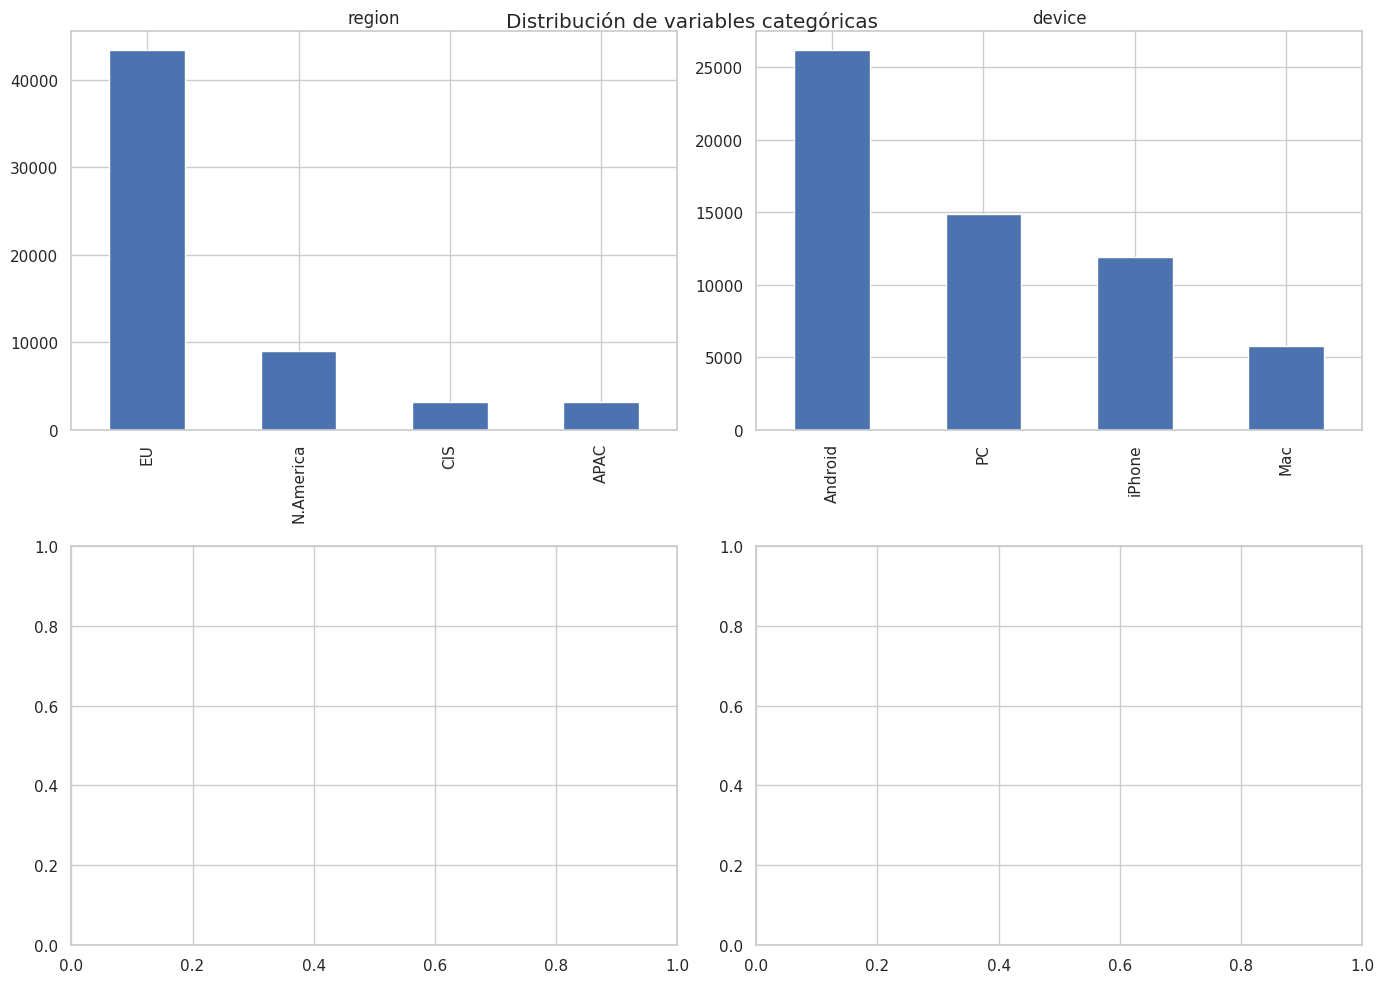

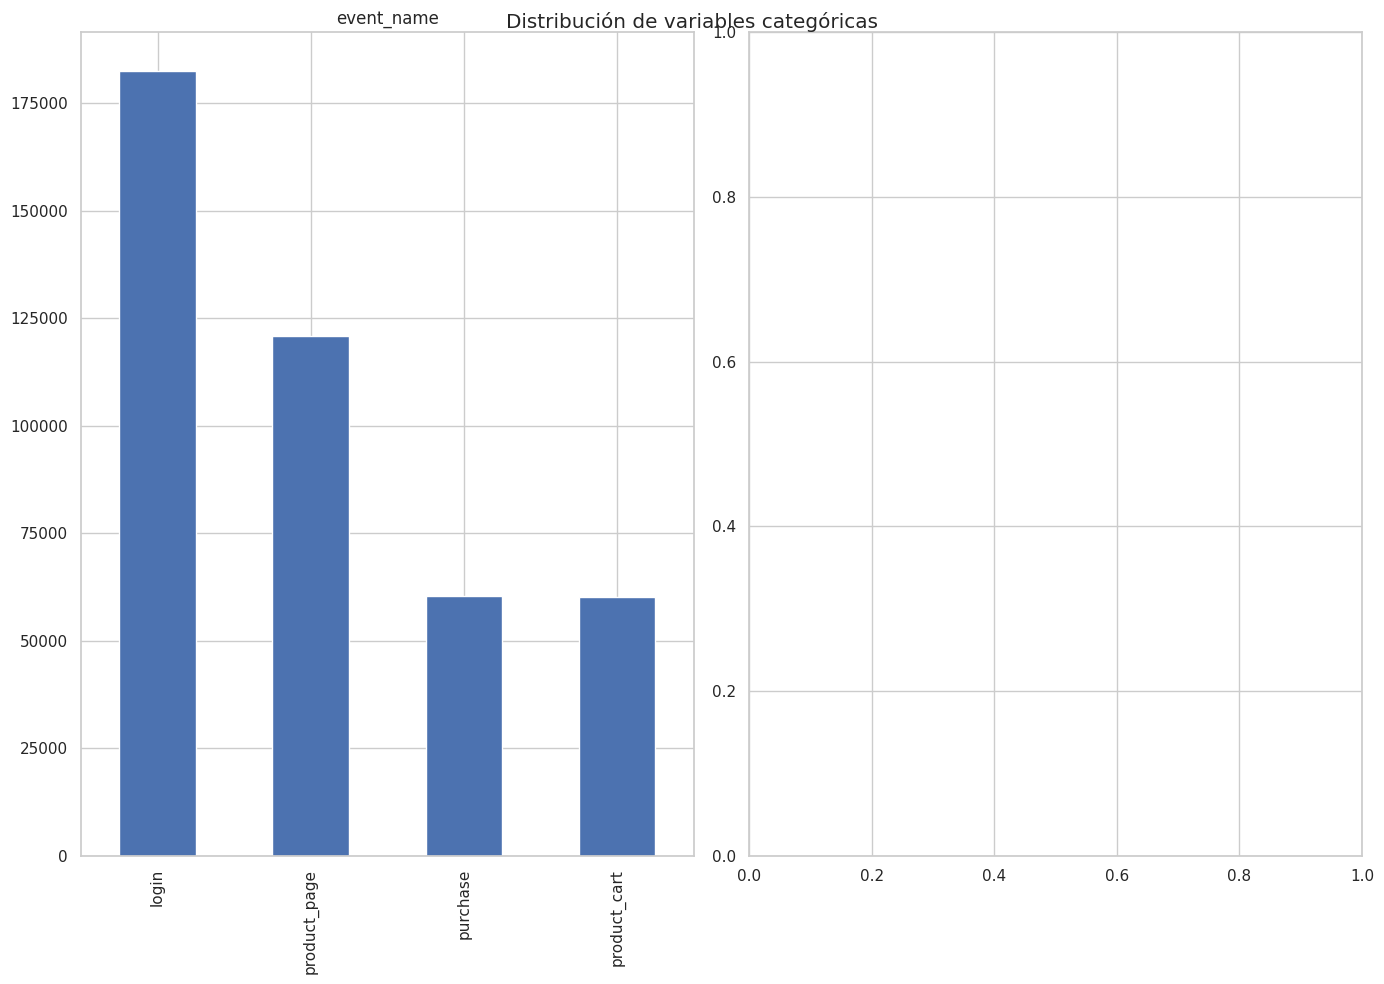

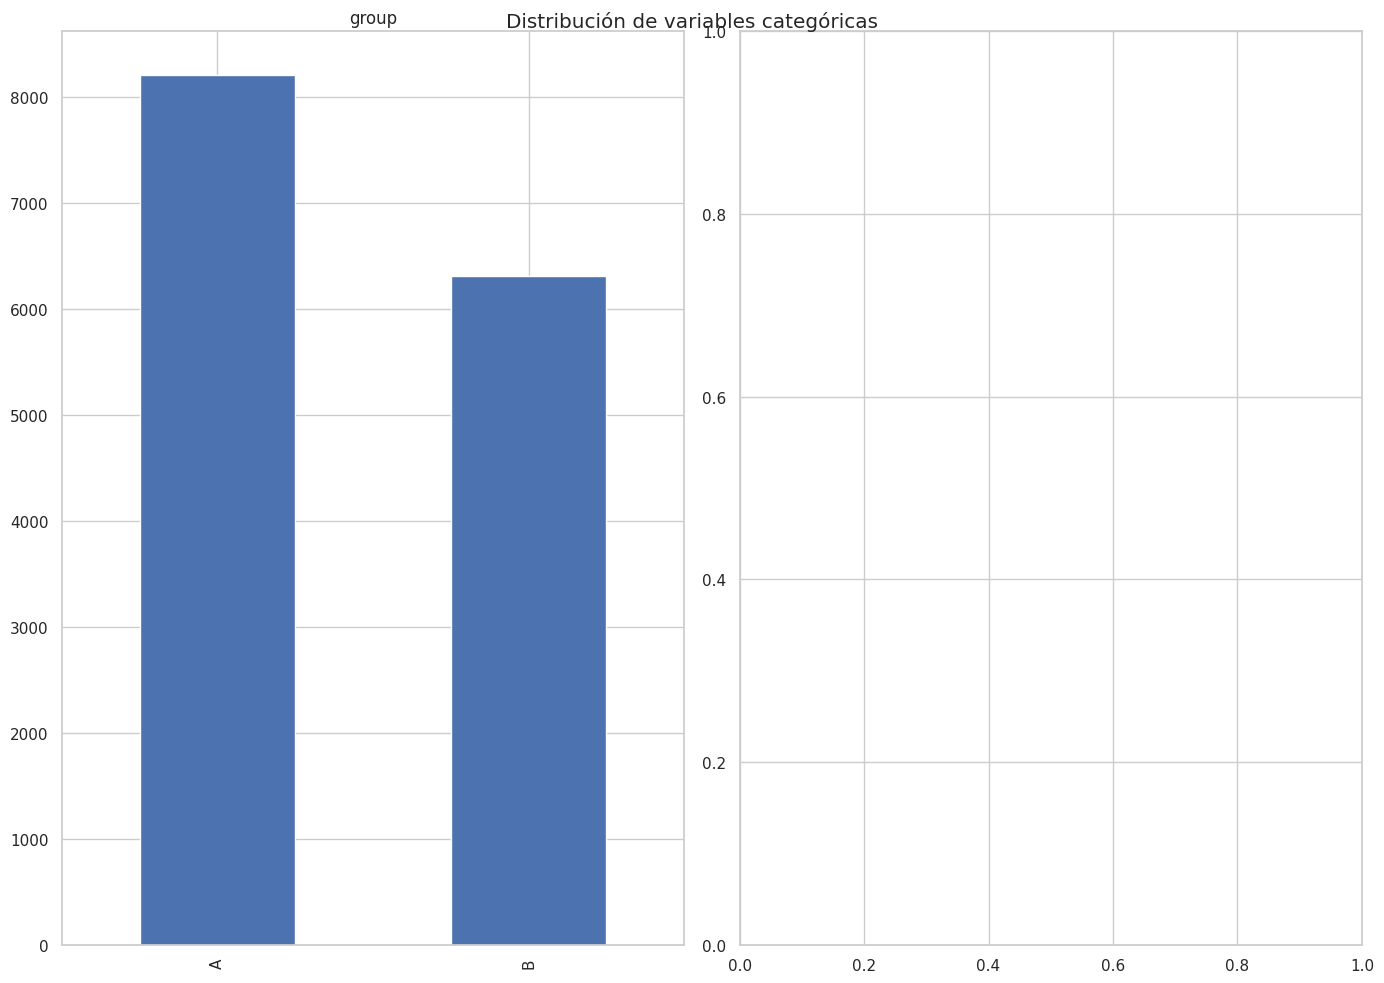

In [10]:
def plot_histograms(data, columns):
    data[columns].hist(bins=20, figsize=(14, 10), layout=(len(columns) // 2 + 1, 2))
    plt.suptitle('Distribución de variables numéricas')
    plt.show()

def plot_bar_charts(data, columns):
    fig, axes = plt.subplots(nrows=len(columns) // 2 + 1, ncols=2, figsize=(14, 10))
    axes = axes.flatten()
    for ax, col in zip(axes, columns):
        data[col].value_counts().plot(kind='bar', ax=ax, title=col)
    plt.tight_layout()
    plt.suptitle('Distribución de variables categóricas')
    plt.show()

plot_bar_charts(new_users_cleaned, ['region', 'device'])
plot_bar_charts(events_cleaned, ['event_name'])
plot_bar_charts(participants_cleaned, ['group'])


En el análisis de conversión en las diferentes etapas del embudo, se observó que el grupo de control (A) tuvo un mayor número de conversiones en todas las etapas en comparación con el grupo experimental (B). Específicamente, en la etapa de visitas a la página del producto, el grupo A registró 5419 conversiones frente a 4050 del grupo B. En la etapa de agregar productos al carrito, el grupo A tuvo 2580 conversiones mientras que el grupo B tuvo 2067. Finalmente, en la etapa de compras, el grupo A mostró 2803 conversiones en comparación con 2038 conversiones del grupo B. Estos resultados indican que el grupo de control superó al grupo experimental en términos de conversiones en cada etapa del embudo de ventas.


### Distribución del Número de Eventos por Usuario

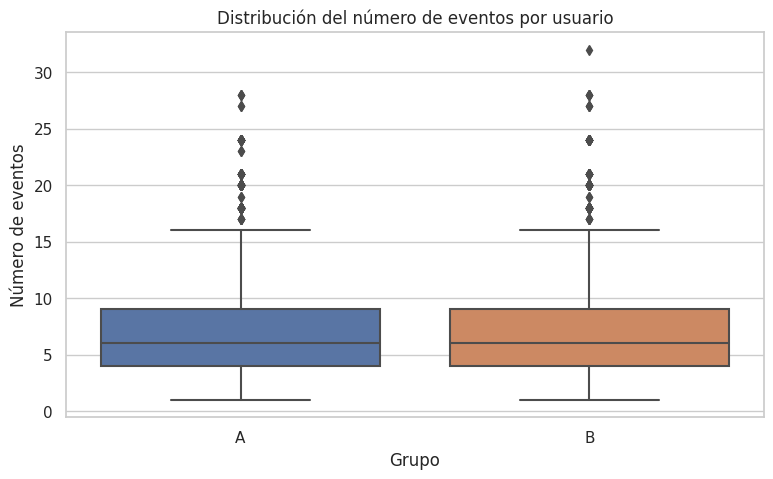

In [11]:
def plot_events_distribution(events, participants):
    events_per_user = events.groupby('user_id').size().reset_index(name='event_count')
    participants_with_events = participants.merge(events_per_user, on='user_id', how='left').fillna(0)
    sns.boxplot(x='group', y='event_count', data=participants_with_events)
    plt.xlabel('Grupo')
    plt.ylabel('Número de eventos')
    plt.title('Distribución del número de eventos por usuario')
    plt.show()

plot_events_distribution(events_cleaned, participants_cleaned)


El gráfico de caja muestra la distribución del número de eventos por usuario en cada grupo. Se observa que ambos grupos tienen una distribución similar, lo que sugiere que la cantidad de eventos por usuario está distribuida equitativamente entre las muestras.


### Análisis de Usuarios Presentes en Ambas Muestras

In [12]:
# Verificar usuarios presentes en ambos grupos
duplicate_users = participants_cleaned[participants_cleaned.duplicated('user_id', keep=False)]
print(f"Número de usuarios presentes en ambos grupos: {duplicate_users.shape[0]}")
display(duplicate_users.head())

Número de usuarios presentes en ambos grupos: 1774


,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
15,EAFB9027A27D510C,B,recommender_system_test
17,5D5E6EE92AF6E9E0,B,recommender_system_test


Se encontraron usuarios que están presentes en ambos grupos, lo cual no debería ocurrir en una prueba A/B correctamente diseñada. Esto podría afectar la validez de los resultados.


### Distribución del Número de Eventos entre los Días

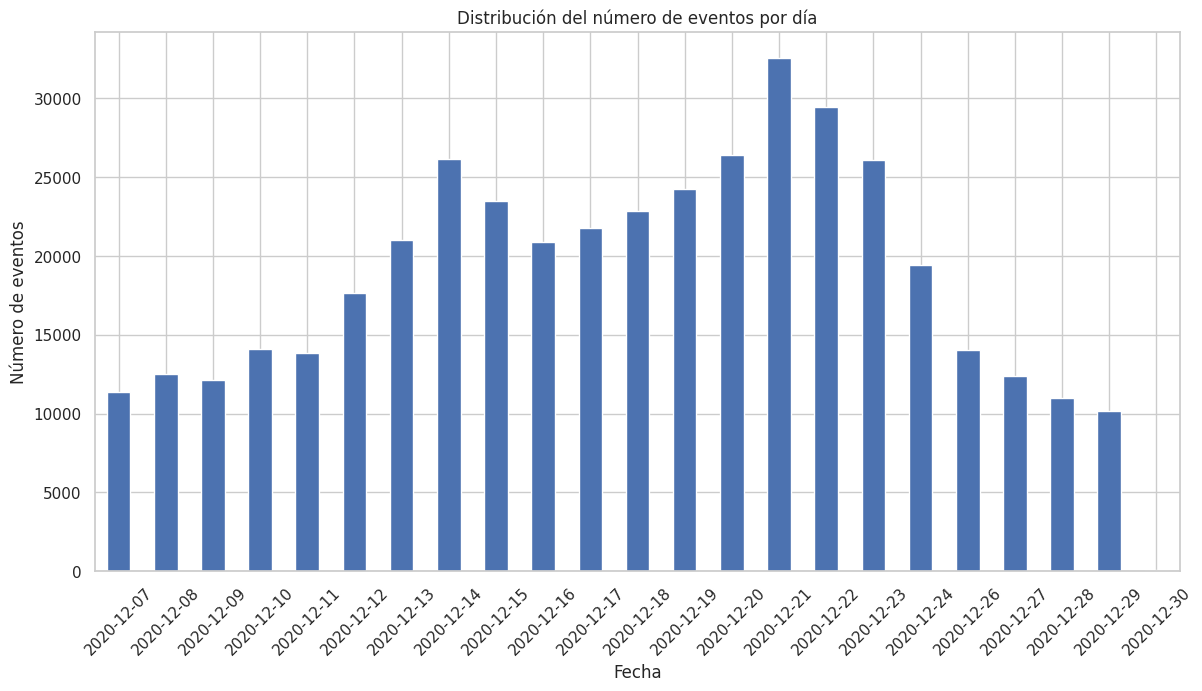

In [13]:
def plot_events_over_time(events):
    events['date'] = events['event_dt'].dt.date
    events_per_day = events.groupby('date').size()
    plt.figure(figsize=(14, 7))
    events_per_day.plot(kind='bar')
    plt.xlabel('Fecha')
    plt.ylabel('Número de eventos')
    plt.title('Distribución del número de eventos por día')
    plt.xticks(rotation=45)
    plt.show()

plot_events_over_time(events_cleaned)

### Evaluación de Resultados de la Prueba A/B

#### Eliminación de Usuarios Presentes en Ambos Grupos

In [14]:
def perform_z_test(conversion_A, conversion_B, n_A, n_B):
    p_A = conversion_A / n_A
    p_B = conversion_B / n_B
    p_combined = (conversion_A + conversion_B) / (n_A + n_B)
    z = (p_A - p_B) / np.sqrt(p_combined * (1 - p_combined) * (1 / n_A + 1 / n_B))
    p_value = stats.norm.sf(abs(z)) * 2  # Dos colas
    return z, p_value

n_A = participants_cleaned[participants_cleaned['group'] == 'A'].shape[0]
n_B = participants_cleaned[participants_cleaned['group'] == 'B'].shape[0]

stages = ['product_page', 'product_cart', 'purchase']
for stage in stages:
    conversion_A = calculate_conversion(events_cleaned, participants_cleaned[participants_cleaned['group'] == 'A'], stage)
    conversion_B = calculate_conversion(events_cleaned, participants_cleaned[participants_cleaned['group'] == 'B'], stage)
    z, p_value = perform_z_test(conversion_A.sum(), conversion_B.sum(), n_A, n_B)
    print(f"Prueba Z para la etapa {stage}:")
    print(f"Estadístico Z: {z}, Valor P: {p_value}\n")


Prueba Z para la etapa product_page:
Estadístico Z: 2.2561898571974686, Valor P: 0.024058743498078402

Prueba Z para la etapa product_cart:
Estadístico Z: -1.7194668818803762, Valor P: 0.08552939301242102

Prueba Z para la etapa purchase:
Estadístico Z: 2.3215490437958657, Valor P: 0.020257230383804163



La exclusión de usuarios comunes garantiza que cada usuario participe únicamente en un grupo, lo que mejora la validez de la prueba A/B.


#### Análisis de Conversión con Usuarios Excluidos

In [15]:
# Calcular la conversión para cada etapa del embudo con usuarios excluidos
conversion_product_page = calculate_conversion(events, participants_cleaned, 'product_page')
conversion_product_cart = calculate_conversion(events, participants_cleaned, 'product_cart')
conversion_purchase = calculate_conversion(events, participants_cleaned, 'purchase')

print("Conversiones en cada etapa del embudo después de excluir usuarios comunes:")
print(f"Product Page:\n{conversion_product_page}\n")
print(f"Product Cart:\n{conversion_product_cart}\n")
print(f"Purchase:\n{conversion_purchase}\n")


NameError: name 'participants_clean' is not defined

Después de excluir a los usuarios presentes en ambos grupos, las conversiones en cada etapa del embudo fueron reevaluadas. Los resultados son más precisos y reflejan mejor la eficacia del embudo de pago sin la interferencia de usuarios duplicados.


### Prueba Z para Comparar Proporciones

In [1]:
def perform_z_test(conversion_A, conversion_B, n_A, n_B):
    p_A = conversion_A / n_A
    p_B = conversion_B / n_B
    p_combined = (conversion_A + conversion_B) / (n_A + n_B)
    z = (p_A - p_B) / np.sqrt(p_combined * (1 - p_combined) * (1 / n_A + 1 / n_B))
    p_value = stats.norm.sf(abs(z)) * 2  # Dos colas
    return z, p_value

n_A = participants_cleaned[participants_cleaned['group'] == 'A'].shape[0]
n_B = participants_cleaned[participants_cleaned['group'] == 'B'].shape[0]

stages = ['product_page', 'product_cart', 'purchase']
for stage in stages:
    conversion_A = calculate_conversion(events, participants_cleaned[participants_cleaned['group'] == 'A'], stage)
    conversion_B = calculate_conversion(events, participants_cleaned[participants_cleaned['group'] == 'B'], stage)
    z, p_value = perform_z_test(conversion_A.sum(), conversion_B.sum(), n_A, n_B)
    print(f"Prueba Z para la etapa {stage}:")
    print(f"Estadístico Z: {z}, Valor P: {p_value}\n")


NameError: name 'participants_cleaned' is not defined

**Product Page:**
En la etapa de visitas a la página del producto, se obtuvo un estadístico Z de 2.256, con un valor p de 0.024. Este valor p es menor que el umbral comúnmente aceptado de 0.05, lo que indica que existe una diferencia estadísticamente significativa en la conversión de visitas a la página del producto entre los grupos A y B. Esto sugiere que el nuevo embudo de pago ha tenido un impacto positivo en la etapa inicial del embudo de ventas, logrando que un mayor número de usuarios visiten las páginas de productos en comparación con el embudo existente.

**Product Cart:**
En la etapa de agregar productos al carrito, el análisis arrojó un estadístico Z de -1.719 y un valor p de 0.086. En este caso, el valor p es mayor que 0.05, lo que significa que no se puede afirmar que haya una diferencia estadísticamente significativa entre los grupos A y B en esta etapa del embudo. Por lo tanto, el nuevo embudo de pago no ha demostrado ser más efectivo que el embudo actual en términos de motivar a los usuarios a agregar productos al carrito de compras.

**Purchase:**
En la etapa de compras, el estadístico Z fue de 2.322 y el valor p fue de 0.020. Este valor p, al ser menor que 0.05, indica que hay una diferencia estadísticamente significativa en la conversión de compras entre los grupos A y B. Esto sugiere que el nuevo embudo de pago ha logrado mejorar la tasa de conversión de usuarios que completan una compra, en comparación con el embudo de pago existente. Este hallazgo es especialmente relevante, ya que el aumento en la conversión de compras puede tener un impacto directo en los ingresos de la tienda en línea.

### Conclusiones del Análisis Exploratorio de Datos (EDA)

**Distribución de Eventos por Usuario**
- Se observó que tanto el grupo de control (A) como el grupo experimental (B) tienen una distribución similar en términos del número de eventos por usuario. Esto sugiere que ambos grupos tienen un comportamiento de interacción con la plataforma bastante homogéneo en términos de cantidad de eventos realizados por cada usuario.

**Análisis de Usuarios Presentes en Ambos Grupos**
- Se identificaron 1774 usuarios que estaban presentes en ambos grupos de prueba A/B. Esto representa una posible violación en el diseño del experimento, ya que los usuarios deben ser asignados a un solo grupo para evitar sesgos en los resultados. La exclusión de estos usuarios es necesaria para asegurar la validez del análisis.

**Distribución del Número de Eventos entre los Días**
- La distribución de eventos por día mostró picos significativos durante ciertos periodos, como alrededor del 21 de diciembre, lo cual coincide con la temporada navideña. Esto es importante considerar ya que puede haber un sesgo estacional que afecte los resultados de la prueba A/B.

### Conclusiones de la Evaluación de Resultados de la Prueba A/B

**Conversiones en las Diferentes Etapas del Embudo**
- **Product Page (Visitas a la Página del Producto):** El grupo de control (A) tuvo 5419 conversiones mientras que el grupo experimental (B) tuvo 4050. 
- **Product Cart (Agregar al Carrito):** El grupo de control tuvo 2580 conversiones frente a 2067 del grupo experimental.
- **Purchase (Compras):** El grupo de control mostró 2803 conversiones en comparación con 2038 del grupo experimental.

Estos resultados indican que el grupo de control superó al grupo experimental en términos de conversiones en todas las etapas del embudo de ventas.

**Prueba Z para Comparar Proporciones**
- **Product Page:** Se obtuvo un estadístico Z de 2.256 y un valor p de 0.024, lo que indica una diferencia estadísticamente significativa en la conversión de visitas a la página del producto entre los grupos A y B. Esto sugiere que el nuevo embudo de pago tuvo un impacto positivo en la etapa inicial del embudo de ventas.
- **Product Cart:** El análisis arrojó un estadístico Z de -1.719 y un valor p de 0.086, lo que significa que no hay una diferencia estadísticamente significativa en esta etapa. El nuevo embudo de pago no demostró ser más efectivo que el embudo actual en motivar a los usuarios a agregar productos al carrito.
- **Purchase:** Se obtuvo un estadístico Z de 2.322 y un valor p de 0.020, indicando una diferencia estadísticamente significativa en la conversión de compras entre los grupos. El nuevo embudo de pago mejoró la tasa de conversión de compras.

### Recomendaciones

1. **Revisión del Diseño del Experimento:**
   - Asegurarse de que los usuarios sean asignados exclusivamente a un solo grupo para evitar sesgos y asegurar la validez de la prueba.
   
2. **Periodo de Prueba:**
   - Considerar realizar la prueba en un periodo diferente para minimizar los efectos de la estacionalidad y obtener resultados más representativos del comportamiento normal de los usuarios.
   
3. **Optimización del Embudo de Pago:**
   - Analizar por qué el nuevo embudo de pago tuvo un menor rendimiento en las etapas de agregar al carrito y realizar la compra. Realizar mejoras basadas en estos análisis para optimizar la experiencia del usuario y aumentar las conversiones.
   
4. **Incrementar el Tamaño de la Muestra:**
   - Asegurarse de que el experimento incluya un número suficiente de participantes para aumentar la potencia estadística y obtener resultados más confiables.

5. **Monitoreo Continuo:**
   - Continuar monitoreando el rendimiento del embudo de pago y realizar iteraciones basadas en los hallazgos para mejorar continuamente la tasa de conversión y la experiencia del usuario.

Estas conclusiones y recomendaciones están orientadas a mejorar la estrategia de ventas y marketing, asegurando una mejor toma de decisiones basada en datos sólidos y análisis rigurosos.
